# Node21 - CT patch preprocessing (by Guillaume Sallé, using generate_2d from NODE21 challenge)

## Imports

In [1]:
from SimpleITK import ReadImage, GetArrayFromImage
from matplotlib.pyplot import hist
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.pyplot import hist
import pandas as pd

## Helping functions

In [2]:
def norm(arr):
    """
    Normalize the array to [-1,1]
    """
    mini=arr.min()
    maxi=arr.max()
    arr2 = (arr-mini)/(maxi-mini)*2-1.0
    arr2[arr2>1]=1.0
    arr2[arr2<-1]=-1.0
    return arr2

def generate_2d(X_ct, p_lambda = 0.85):
    '''
    Taken from NODE21 Challenge.
    Generate 2D digitally reconstructed radiographs from CT scan. (DRR, fake CXR, simulated CXR)
    X_ct: CT scan
    p-lambda:  β controls the boosting of X-ray absorption as the tissue density increases.
    We have chosen β=0.85 for our experiments after performing a visual comparison with real chest X-rays.
    '''
    X_ct[X_ct > 400] = 400
    X_ct[X_ct < -500] = -500
    X_ct += 1024
    # 1424 524 698.748232
    X_ct = X_ct/1000.0
    X_ct *= p_lambda
    X_ct[X_ct > 1] = 1
    #1.0 0.4454 0.5866707652
    X_ct_2d = np.mean(np.exp(X_ct), axis=1)
    return X_ct_2d

## Main pipeline : process CT nodules and adapt corresponding

In [3]:
patch_path = os.path.join(".","..","dataset_node21_MODIFIED","ct_patches","nodule_patches")
patchseg_path = os.path.join(".","..","dataset_node21_MODIFIED","ct_patches","segmentation")
target_path = os.path.join(".","patch_v8nokmeans")
CSV_containg_diameters_path = os.path.join(".","..","generation_baselineGS","ct_nodules.csv")
CSV_target = os.path.join(".","ct_nodules_v8nokmeans.csv")
os.makedirs(target_path, exist_ok=True)

patch_files = sorted(os.listdir(patch_path))
tab = []
NaN_files = []
for i,f in enumerate(patch_files):
    # Load CT nodule
    seg_name = f.replace("dcm", "seg")
    patch = GetArrayFromImage(ReadImage(os.path.join(patch_path,f)))
    seg = GetArrayFromImage(ReadImage(os.path.join(patchseg_path,seg_name)))
    # Extract nodule and put minimum value of the patch as background
    patch_only = patch #* seg
    patch_only[patch_only==0]=np.min(patch)
    # Generate 2D nodule and corresponding mask (by stacking the previous)
    patch_stack = norm(generate_2d(patch_only))
    # Sometimes it generates an array with only one value inside
    # It creates a NaN when normalizing the array
    # -> We don't save the nodule when there is a NaN
    if not(np.isnan(patch_stack).any()):
        seg_stack = np.sum(seg, axis=1)
        seg_stack[seg_stack>=1] = 1
        seg_stack[seg_stack<1] = 0
        patch_stack[seg_stack==0] = 0
        # Save results
        tab.append(np.mean(patch_stack[seg_stack>0]))
        if np.isnan(patch_stack).any():
            print("NaN in "+f)
        np.save(os.path.join(target_path, f[:-3]+"npy"), patch_stack)
        np.save(os.path.join(target_path, seg_name[:-3]+"npy"), seg_stack)
    else:
        NaN_files.append(f)
        
    #VISU = True
    VISU = False
    if VISU:
        plt.subplot(1,2,1)
        plt.imshow(patch_stack, cmap="gray", vmin=-1.0, vmax=1.0)
        plt.subplot(1,2,2)
        plt.imshow(seg_stack, cmap="gray", vmin=0.0, vmax=1.0)
        plt.show()
        if i==3:
            break

# Just to check that there is no NaN
print("NaN found in some files ("+str(len(NaN_files))+"): "+str(NaN_files))
for f in os.listdir(target_path):
    if "seg" not in f:
        a = np.load(os.path.join(target_path, f))
        if np.isnan(a).any():
            print("there's still a problem")

# Remove NaN nodules from CSV containing diameters
indices_to_drop = []
CSV_containg_diameters = pd.read_csv(CSV_containg_diameters_path)
# Find indices corresponding to NaN files
for val in CSV_containg_diameters.values:
    if val[1] in NaN_files:
        indices_to_drop.append(val[0])
# Drop these indices and remove first column (replaced automatically pandas)
CSV_corrected = CSV_containg_diameters.drop(indices_to_drop)
CSV_corrected = CSV_corrected.drop(["Unnamed: 0"], axis=1)
# Just to check that there is no more NaN filename
for val in CSV_corrected.values:
    if val[1] in NaN_files:
        print("there's still a problem with the CSV")

CSV_corrected.to_csv(CSV_target)
print("New CSV saved")

NaN found in some files (0): []
New CSV saved


(array([332., 209., 203., 166., 140.,  89.,  30.,  10.,   5.,   2.]),
 array([-1.        , -0.83436865, -0.66873729, -0.50310594, -0.33747458,
        -0.17184323, -0.00621188,  0.15941948,  0.32505083,  0.49068219,
         0.65631354]),
 <BarContainer object of 10 artists>)

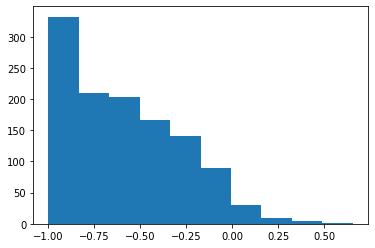

In [4]:
hist(tab)